In [3]:
import finnhub
from datetime import datetime, timedelta
import configparser
import pandas as pd

# Initialize the config parser
config = configparser.ConfigParser()
config.read(r'C:\Users\jbhan\Desktop\StockMarketNewsImpact\FinnhubAPI\config.ini')

# Retrieve the API key from the config file
api_key = config.get('finnhub', 'api_key')

# Initialize the Finnhub client
finnhub_client = finnhub.Client(api_key=api_key)

# Define the date range
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Convert dates to the required format
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

# Fetch news articles
news = finnhub_client.company_news('TSLA', _from=start_date_str, to=end_date_str)
# len(news)

In [ ]:
import finnhub
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
import re


# Define date range for a year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Load the LabMT word list
file_path = r"C:\Users\jbhan\Desktop\StockMarketNewsImpact\FinnhubAPI\LabMT_wordlist.txt"
df = pd.read_csv(file_path, sep='\s+', skiprows=2)
labmt_lexicon = dict(zip(df['word'], df['happiness_average']))

def calculate_sentiment(tokens):
    """Calculate sentiment score using LabMT lexicon."""
    sentiments = [labmt_lexicon.get(word, 5.0) for word in tokens]
    return np.mean(sentiments) if sentiments else 5.0  # Neutral score if no words found

def tokenize(text):
    """Simple tokenization function."""
    return re.findall(r'\b\w+\b', text.lower())

def fetch_news_sentiment(symbol, start, end):
    """Fetch news in chunks and calculate sentiment using LabMT."""
    news_data = []
    current_start_date = start
    while current_start_date < end:
        chunk_end_date = min(current_start_date + timedelta(days=7), end)
        start_str = current_start_date.strftime('%Y-%m-%d')
        end_str = chunk_end_date.strftime('%Y-%m-%d')

        # Fetch news for the date chunk
        news_chunk = finnhub_client.company_news(symbol, _from=start_str, to=end_str)
        
        for article in news_chunk:
            tokens = tokenize(article['summary'])
            sentiment_score = calculate_sentiment(tokens)
            news_data.append({
                'id': article['id'],
                'datetime': datetime.fromtimestamp(article['datetime']),
                'headline': article['headline'],
                'sentiment_score': sentiment_score,
                'url': article['url']
            })

        current_start_date = chunk_end_date + timedelta(days=1)

    # Remove duplicates based on 'id'
    return pd.DataFrame(news_data).drop_duplicates(subset='id')

# Fetch news and sentiment data for the company (e.g., TSLA)
news_df = fetch_news_sentiment('TSLA', start_date, end_date)

# Build a graph from the news data
G = nx.Graph()
for i, article in news_df.iterrows():
    G.add_node(i, title=article['headline'], date=article['datetime'], url=article['url'], sentiment=article['sentiment_score'])

# Add edges between nodes based on similar sentiment scores
threshold = 0.25  # Adjust threshold to connect nodes with similar sentiment
for i in range(len(news_df)):
    for j in range(i + 1, len(news_df)):
        if abs(news_df.iloc[i]['sentiment_score'] - news_df.iloc[j]['sentiment_score']) < threshold:
            G.add_edge(i, j, weight=1 - abs(news_df.iloc[i]['sentiment_score'] - news_df.iloc[j]['sentiment_score']))

# Apply Louvain clustering
partition = community_louvain.best_partition(G)

# Color nodes based on their cluster
num_clusters = len(set(partition.values()))
color_map = plt.cm.get_cmap('viridis', num_clusters)
node_colors = [color_map(partition[node]) for node in G.nodes()]

# Draw the graph with a spring layout
pos = nx.spring_layout(G, k=0.5)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5)
plt.title('Louvain Clustering of News Articles Based on LabMT Sentiment Scores')
plt.show()

# Display cluster details
cluster_details = {}
for node, cluster_id in partition.items():
    if cluster_id not in cluster_details:
        cluster_details[cluster_id] = []
    cluster_details[cluster_id].append({
        'headline': G.nodes[node]['title'],
        'sentiment': G.nodes[node]['sentiment']
    })

# Print sample headlines and sentiments from each cluster
for cluster_id, articles in cluster_details.items():
    print(f"\nCluster {cluster_id} - Number of Articles: {len(articles)}")
    print(f"Average Sentiment: {np.mean([article['sentiment'] for article in articles]):.2f}")
    for article in articles[:3]:  # Display up to 3 articles per cluster
        print(f"  - {article['headline']} (Sentiment Score: {article['sentiment']:.2f})")


FinnhubAPIException: FinnhubAPIException(status_code: 429): API limit reached. Please try again later. Remaining Limit: 0

C:\Users\jbhan\AppData\Local\Temp\ipykernel_8912\720554179.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', num_clusters)
c:\Users\jbhan\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


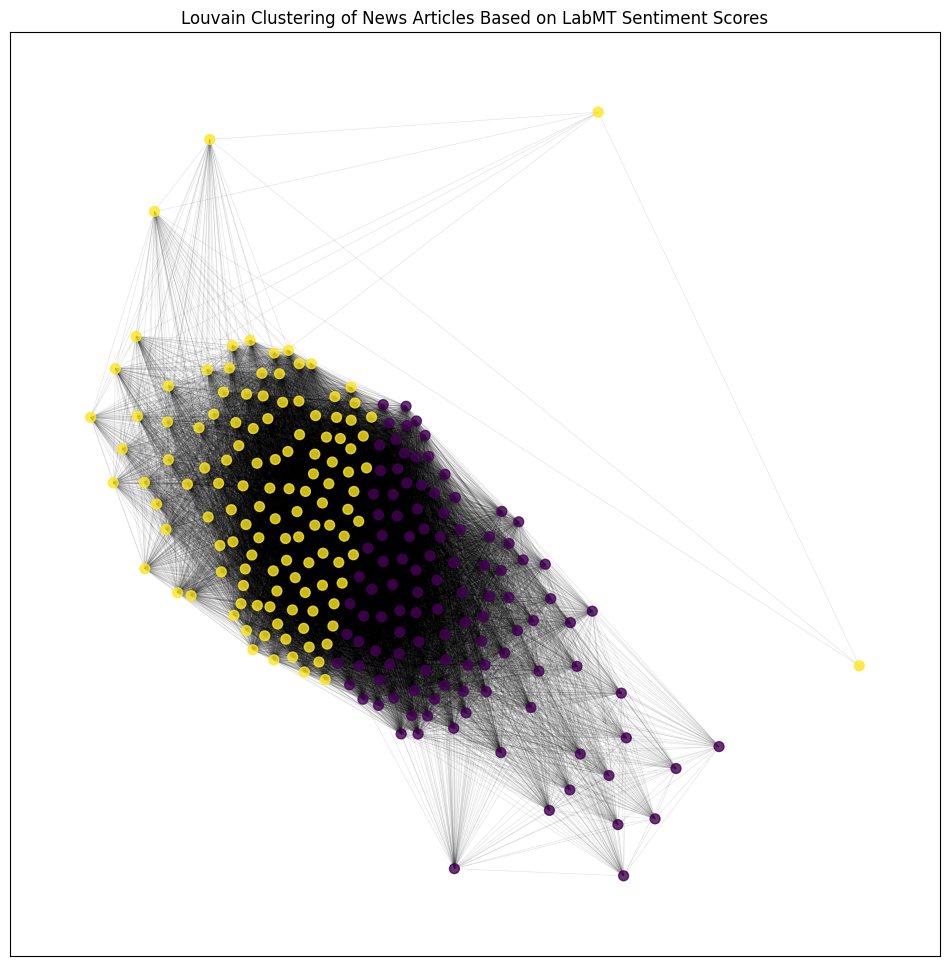


Cluster 0 - Number of Articles: 112
Average Sentiment: 5.53
  - Tesla stock soars 10% as Wall Street grows more bullish after 'gamechanger' election (Sentiment Score: 5.41)
  - How a Trump presidency would impact Big Tech (Sentiment Score: 5.42)
  - Tesla Stock Furthers Post-Election Surge, Gets Boost From Wedbush Analysts (Sentiment Score: 5.53)

Cluster 1 - Number of Articles: 123
Average Sentiment: 5.29
  - Now Back Above $1 Trillion, Tesla Keeps Climbing (Sentiment Score: 5.41)
  - 5 Best ETFs of 2024's Top Week Courtesy Trump Win, Fed Rate Cut (Sentiment Score: 5.32)
  - Hedge funds shorting Tesla stock have lost over $5B: BBG (Sentiment Score: 5.30)


In [186]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# Initialize the graph
G = nx.Graph()

# Add nodes with article details
for i, article in enumerate(news):
    G.add_node(i, title=article['headline'], date=article['datetime'], url=article['url'], sentiment=article['sentiment_score'])

# Add edges between nodes based on similar sentiment scores
threshold = 0.25  # Adjust threshold as needed to connect nodes with similar sentiment
for i in range(len(news)):
    for j in range(i + 1, len(news)):
        if abs(news[i]['sentiment_score'] - news[j]['sentiment_score']) < threshold:
            G.add_edge(i, j, weight=1 - abs(news[i]['sentiment_score'] - news[j]['sentiment_score']))

# Apply Louvain clustering
partition = community_louvain.best_partition(G)

# Color nodes based on their cluster
num_clusters = len(set(partition.values()))
color_map = plt.cm.get_cmap('viridis', num_clusters)
node_colors = [color_map(partition[node]) for node in G.nodes()]

# Draw the graph with the Force Atlas 2 layout if available, or spring layout
pos = nx.spring_layout(G, k=0.5)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5)
plt.title('Louvain Clustering of News Articles Based on LabMT Sentiment Scores')
plt.show()

# Example of inspecting clusters
cluster_details = {}
for node, cluster_id in partition.items():
    if cluster_id not in cluster_details:
        cluster_details[cluster_id] = []
    cluster_details[cluster_id].append({
        'headline': G.nodes[node]['title'],
        'sentiment': G.nodes[node]['sentiment']
    })

# Display sample headlines and sentiments from each cluster
for cluster_id, articles in cluster_details.items():
    print(f"\nCluster {cluster_id} - Number of Articles: {len(articles)}")
    print(f"Average Sentiment: {np.mean([article['sentiment'] for article in articles]):.2f}")
    for article in articles[:3]:  # Display up to 3 articles per cluster as a sample
        print(f"  - {article['headline']} (Sentiment Score: {article['sentiment']:.2f})")


In [187]:
# Dictionary to store headlines and sources for each cluster
cluster_details = {}

# Iterate through nodes and group by cluster
for node, cluster_id in partition.items():
    if cluster_id not in cluster_details:
        cluster_details[cluster_id] = []
    
    # Append the headline, source, and url of each article in the cluster
    cluster_details[cluster_id].append({
        'headline': G.nodes[node]['title'],
        'source': news[node].get('source', 'Unknown'),  # Assuming 'source' field exists in the news data
        'url': news[node]['url'],
        'sentiment': G.nodes[node]['sentiment']
    })

# Display headlines and sources for each cluster
for cluster_id, articles in cluster_details.items():
    print(f"\nCluster {cluster_id} - Number of Articles: {len(articles)}")
    print(f"Average Sentiment: {np.mean([article['sentiment'] for article in articles]):.2f}")
    print("Sample Articles:")
    for article in articles[:5]:  # Display up to 5 articles per cluster as a sample
        print(f"  - {article['headline']} (Source: {article['source']})")
        print(f"    URL: {article['url']}")
        print(f"    Sentiment Score: {article['sentiment']:.2f}")



Cluster 0 - Number of Articles: 112
Average Sentiment: 5.53
Sample Articles:
  - Tesla stock soars 10% as Wall Street grows more bullish after 'gamechanger' election (Source: Yahoo)
    URL: https://finnhub.io/api/news?id=98181b2cb1d9ad3ea4dcdfdfd48fd61cc28e5a6748da8afe1519160fd7dceb4f
    Sentiment Score: 5.41
  - How a Trump presidency would impact Big Tech (Source: Yahoo)
    URL: https://finnhub.io/api/news?id=caf3fb0960190bf58dd990c1965606d09b07a3b25bf0e92d749dc97f98a343ae
    Sentiment Score: 5.42
  - Tesla Stock Furthers Post-Election Surge, Gets Boost From Wedbush Analysts (Source: Yahoo)
    URL: https://finnhub.io/api/news?id=29f72e419cf6befe82b69a98b023c9954b990dd4eacc7c6faf4722767c997e75
    Sentiment Score: 5.53
  - Tesla, bitcoin and dollar jump as investors pile into ‘Trump trades’ (Source: Yahoo)
    URL: https://finnhub.io/api/news?id=1039a403080c33f1ef084ada4604f61a5b04e6fcbc61f89e156b43abada35053
    Sentiment Score: 5.71
  - Tesla Stock Soars Again. Short Sellers A

C:\Users\jbhan\AppData\Local\Temp\ipykernel_8912\940163406.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', num_clusters)
c:\Users\jbhan\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


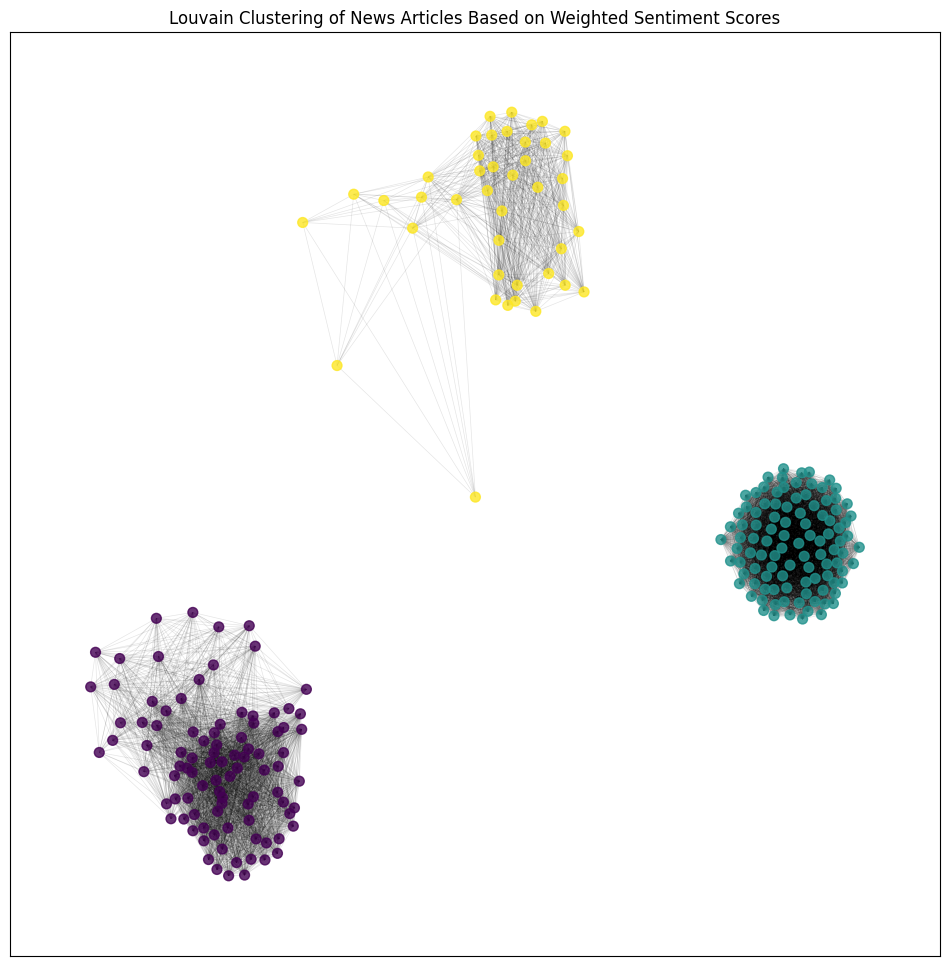

In [ ]:
from transformers import pipeline
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, pipeline


# Load the FinBERT model for sentiment analysis
finbert_sentiment = pipeline("sentiment-analysis", model="ProsusAI/finbert", tokenizer="ProsusAI/finbert", truncation=True, max_length=128, device=0)

def analyze_sentiment(text):
    # Get the full output with confidence scores for each label
    results = finbert_sentiment(text)
    
    # Confidence scores for each sentiment
    positive_score = next((item['score'] for item in results if item['label'] == 'positive'), 0)
    negative_score = next((item['score'] for item in results if item['label'] == 'negative'), 0)
    neutral_score = next((item['score'] for item in results if item['label'] == 'neutral'), 0)
    
    # Calculate a weighted sentiment score:
    # Positive = +1.0, Neutral = 0.0, Negative = -1.0
    sentiment_score = positive_score * 1.0 + neutral_score * 0.0 + negative_score * -1.0
    
    return sentiment_score

# Example of sentiment analysis using FinBERT. Adjustimg for short sellers
def adjust_sentiment_for_short_sellers(text, original_score):
    # Define keywords related to short-selling and losses
    short_seller_keywords = ["short-seller", "shorting", "shorts", "hammered", "loss", "hit", "crushed"]
    
    # Check if any short-seller keywords are in the text
    if any(keyword in text.lower() for keyword in short_seller_keywords):
        # If sentiment score is negative due to short-seller context, make it positive
        return abs(original_score) if original_score < 0 else original_score
    else:
        # Otherwise, keep the original score
        return original_score

# Apply the adjustment function after FinBERT analysis
for article in news:
    sentiment_score = analyze_sentiment(article['summary'])  # FinBERT score
    article['sentiment_score'] = adjust_sentiment_for_short_sellers(article['summary'], sentiment_score)


# Initialize the graph
G = nx.Graph()

# Add nodes with article details
for i, article in enumerate(news):
    G.add_node(i, title=article['headline'], date=article['datetime'], url=article['url'], sentiment=article['sentiment_score'])

# Add edges based on sentiment similarity
threshold = 0.25  # Adjust threshold as needed to connect nodes with similar sentiment scores
for i in range(len(news)):
    for j in range(i + 1, len(news)):
        if abs(news[i]['sentiment_score'] - news[j]['sentiment_score']) < threshold:
            G.add_edge(i, j, weight=1 - abs(news[i]['sentiment_score'] - news[j]['sentiment_score']))

# Apply Louvain clustering
partition = community_louvain.best_partition(G)

# Assign colors based on clusters
num_clusters = len(set(partition.values()))
color_map = plt.cm.get_cmap('viridis', num_clusters)
node_colors = [color_map(partition[node]) for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5)
plt.title('Louvain Clustering of News Articles Based on Weighted Sentiment Scores')
plt.show()


In [209]:
# Create a dictionary to store headlines and sources for each cluster
cluster_details = {}
for node, cluster_id in partition.items():
    if cluster_id not in cluster_details:
        cluster_details[cluster_id] = []
    
    cluster_details[cluster_id].append({
        'headline': G.nodes[node]['title'],
        'sentiment': G.nodes[node]['sentiment'],
        'url': G.nodes[node]['url']
    })

# Display sample headlines and sentiments from each cluster
for cluster_id, articles in cluster_details.items():
    print(f"\nCluster {cluster_id} - Number of Articles: {len(articles)}")
    print(f"Average Sentiment: {np.mean([article['sentiment'] for article in articles]):.2f}")
    for article in articles[:3]:  # Display up to 3 articles per cluster as a sample
        print(f"  - {article['headline']} (Sentiment Score: {article['sentiment']:.2f})")
        print(f"    URL: {article['url']}")



Cluster 0 - Number of Articles: 94
Average Sentiment: 0.78
  - How Big Tech, AI could fit into Trump's immigration policies (Sentiment Score: 0.90)
    URL: https://finnhub.io/api/news?id=437d4b37fba4fb8fe927dc203eb3bc53c32813b9e982ad54e7291b08028a1ca6
  - Nvidia Stock Called 'Must-Own,' 'Once-In-A-Lifetime Opportunity' (Sentiment Score: 0.94)
    URL: https://finnhub.io/api/news?id=b815df049f3cee0bbeb5d209929ad0a2c2fb5d595139cbb03167d175520656bf
  - Single-Stock ETFs Dominate the Best Week's Rally of 2024 (Sentiment Score: 0.94)
    URL: https://finnhub.io/api/news?id=97d2cea579f5b21a6443f7345c185bbe72d9f0636938a2fb076920afd332039c

Cluster 1 - Number of Articles: 102
Average Sentiment: 0.00
  - Morgan Stanley Lifts Nvidia Target as Blackwell Product Sales Surge (Sentiment Score: 0.00)
    URL: https://finnhub.io/api/news?id=98350f188738e63b4a8b89ad963a852f170fff9ef0c5eb384317cd6220a46039
  - How a Trump presidency would impact Big Tech (Sentiment Score: 0.00)
    URL: https://finnhu

In [244]:
# List of company symbols
companies = ['AAPL', 'TSLA', 'GOOGL', 'MSFT', 'META', 'AMZN', 'NVDA']

# Define the time frame (e.g., past 365 days)
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')
news = finnhub_client.company_news("TSLA", _from=start_str, to=end_str)

news[0]

{'category': 'company',
 'datetime': 1731343107,
 'headline': "Tesla stock soars 10% as Wall Street grows more bullish after 'gamechanger' election",
 'id': 131287193,
 'image': 'https://s.yimg.com/ny/api/res/1.2/70h6WRVFKTYa0Xqc5iOEYQ--/YXBwaWQ9aGlnaGxhbmRlcjt3PTEyMDA7aD04MDA-/https://s.yimg.com/os/creatr-uploaded-images/2024-10/55b2f100-9fa7-11ef-bd6a-4c0c05d08632',
 'related': 'TSLA',
 'source': 'Yahoo',
 'summary': "Tesla stock surged for a fifth straight session on Monday as the company continues to benefit from its CEO's relationship with President-elect Donald Trump.",
 'url': 'https://finnhub.io/api/news?id=98181b2cb1d9ad3ea4dcdfdfd48fd61cc28e5a6748da8afe1519160fd7dceb4f'}

In [ ]:
import finnhub
import pandas as pd
from datetime import datetime, timedelta
from transformers import pipeline
from tqdm import tqdm

# Initialize the FinBERT sentiment analysis pipeline
finbert_sentiment = pipeline("sentiment-analysis", model="ProsusAI/finbert", tokenizer="ProsusAI/finbert", truncation=True, max_length=128, device=0)


# List of company symbols
companies = ['AAPL', 'TSLA', 'GOOGL', 'MSFT', 'META', 'AMZN', 'NVDA']

# Define the time frame (e.g., past 365 days)
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

def analyze_sentiment_with_finbert(text):
    """Analyze sentiment using FinBERT and return a numerical score."""
    result = finbert_sentiment(text)[0]
    if result['label'] == 'positive':
        return 1.0
    elif result['label'] == 'negative':
        return -1.0
    else:
        return 0.0

def fetch_news_sentiment(symbol, start, end):
    """Fetch news for a given company in smaller chunks and calculate sentiment using FinBERT."""
    news_data = []
    
    # Loop through the date range in smaller chunks (e.g., 2 days)
    current_start_date = start
    with tqdm(total=(end - start).days // 2, desc=f"Fetching {symbol}", leave=False) as pbar:
        while current_start_date < end:
            # Define the chunk end date
            chunk_end_date = min(current_start_date + timedelta(days=2), end)
            
            # Convert dates to ISO format
            start_str = current_start_date.strftime('%Y-%m-%d')
            end_str = chunk_end_date.strftime('%Y-%m-%d')
            
            # Fetch company news for the date chunk
            news_chunk = finnhub_client.company_news(symbol, _from=start_str, to=end_str)
            
            # Extract relevant information and analyze sentiment
            for article in news_chunk:
                # Check if datetime is in milliseconds or seconds
                timestamp = article['datetime']
                date = datetime.fromtimestamp(timestamp / 1000) if timestamp > 1e12 else datetime.fromtimestamp(timestamp)
                headline = article['headline']
                
                # Calculate sentiment score using FinBERT
                sentiment_score = analyze_sentiment_with_finbert(headline)
                
                news_data.append({'id': article['id'], 'date': date, 'headline': headline, 'sentiment': sentiment_score})
            
            # Move the start date forward for the next chunk
            current_start_date = chunk_end_date + timedelta(days=1)
            
            # Update progress bar
            pbar.update(1)

    # Convert to DataFrame and remove duplicates based on 'id'
    news_df = pd.DataFrame(news_data).drop_duplicates(subset='id')
    return news_df

# Fetch news and sentiment data for all companies with an outer tqdm loop
all_news = pd.DataFrame()
for company in tqdm(companies, desc="Processing companies"):
    news_df = fetch_news_sentiment(company, start_date, end_date)
    news_df['company'] = company  # Add the company name to the DataFrame
    all_news = pd.concat([all_news, news_df], ignore_index=True)

# Display the collected news with sentiment scores
print(all_news.head())
print(f"Total unique articles fetched: {len(all_news)}")


          id                date  \
0  123962161 2023-11-18 00:49:00   
1  123966891 2023-11-18 00:20:39   
2  123964133 2023-11-17 23:54:00   
3  123964136 2023-11-17 23:20:56   
4  123980888 2023-11-17 23:03:00   

                                            headline  sentiment company  
0                                     Weekly Roundup        0.0    AAPL  
1  ChatGPT: Everything you need to know about the...        0.0    AAPL  
2  Apple rolls out texting updates for messaging ...        0.0    AAPL  
3  Google antitrust: The risk a ruling could pose...        0.0    AAPL  
4                   Elon Musk's X apocalyptic moment        0.0    AAPL  
Total unique articles fetched: 109586


In [36]:
# save the data to a CSV file
all_news.to_csv('news_sentiment_data.csv', index=False)

In [26]:
print(all_news["company"].value_counts())
all_news["sentiment"].value_counts()

company
NVDA     19400
AAPL     16490
TSLA     16254
MSFT     16247
AMZN     15501
GOOGL    14390
META     11304
Name: count, dtype: int64


sentiment
 0.0    66621
 1.0    21646
-1.0    21319
Name: count, dtype: int64

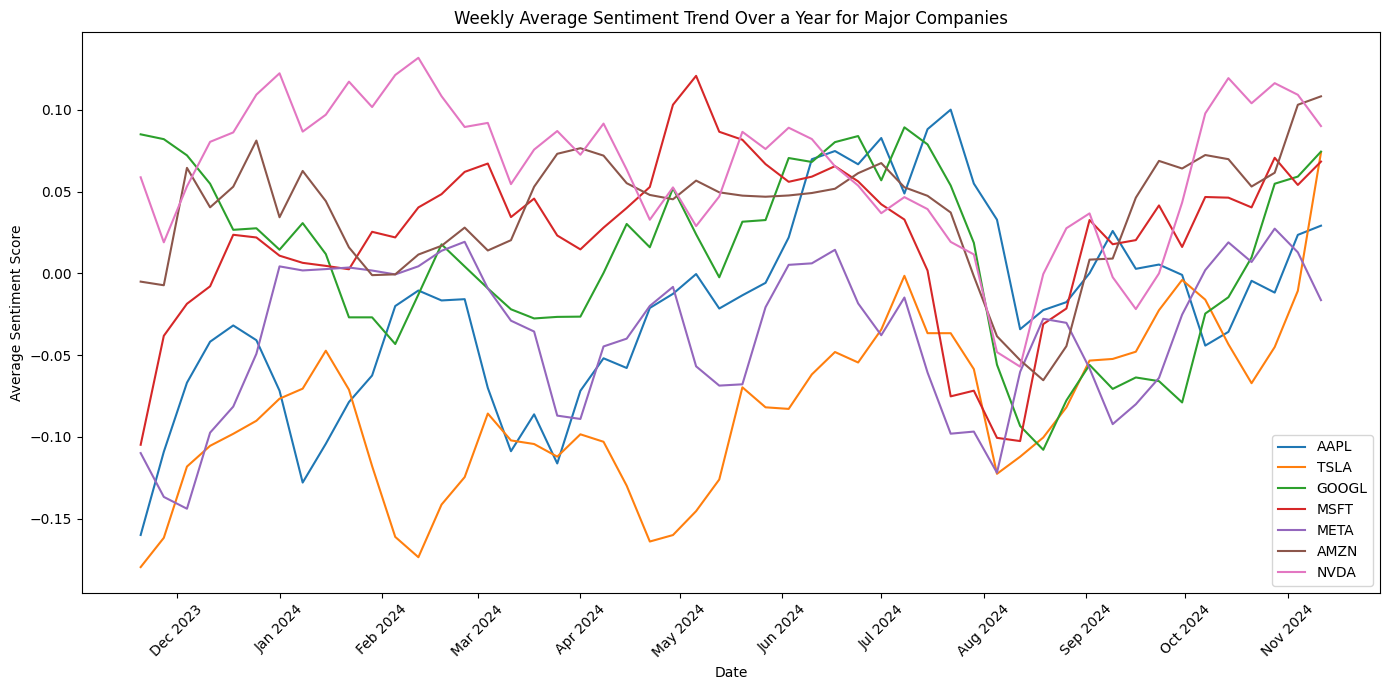

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Ensure 'date' is in datetime format and filter relevant dates
all_news['date'] = pd.to_datetime(all_news['date'])
all_news = all_news[(all_news['date'] >= start_date) & (all_news['date'] <= end_date)]

# Set 'date' as the index
all_news.set_index('date', inplace=True)

# Resample the data by week for each company and calculate the mean sentiment score
weekly_sentiment = all_news.groupby('company').resample('W-MON')['sentiment'].mean().reset_index()

# Plot the weekly average sentiment scores with a 4-week rolling average for smoothing
plt.figure(figsize=(14, 7))
for company in companies:
    company_data = weekly_sentiment[weekly_sentiment['company'] == company]
    plt.plot(company_data['date'], company_data['sentiment'].rolling(window=4, min_periods=1).mean(), label=company)

# Customize the plot
plt.xlabel("Date")
plt.ylabel("Average Sentiment Score")
plt.title("Weekly Average Sentiment Trend Over a Year for Major Companies")
plt.legend()

# Format x-axis for a year-long plot
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Show month and year
plt.xticks(rotation=45)  # Rotate date labels for readability

plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
all_news_path = r"C:\Users\jbhan\Desktop\StockMarketNewsImpact\FinnhubAPI\news_sentiment_data.csv"
all_news = pd.read_csv(all_news_path)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from fa2_modified import ForceAtlas2
import community as community_louvain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import numpy as np

# Step 1: Convert headlines to TF-IDF features for similarity computation (sparse)
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(all_news['headline'])

# Step 2: Compute sparse cosine similarity matrix (only retain similarities > 0.3)
cosine_similarities = cosine_similarity(tfidf_matrix, dense_output=False)
cosine_similarities = cosine_similarities.multiply(cosine_similarities > 0.3)  # Apply threshold

# Step 3: Create the Graph with Articles as Nodes
G = nx.Graph()

# Add nodes for each article
for i, article in all_news.iterrows():
    G.add_node(i, company=article['company'], sentiment=article['sentiment'], headline=article['headline'])

# Step 4: Add edges based on sparse similarity matrix
rows, cols = cosine_similarities.nonzero()
for row, col in zip(rows, cols):
    if row < col:  # Avoid duplicate edges in an undirected graph
        G.add_edge(row, col, weight=cosine_similarities[row, col])

# Step 5: Apply Force Atlas 2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,
    verbose=True
)

# Compute layout
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=50)

# Step 6: Apply Louvain clustering
partition = community_louvain.best_partition(G)

# Step 7: Visualize the graph with clusters
plt.figure(figsize=(14, 14))
colors = [partition[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, positions, node_size=20, node_color=colors, cmap=plt.cm.jet)
nx.draw_networkx_edges(G, positions, alpha=0.1)

plt.title("Louvain Clusters of News Articles (Force Atlas 2 Layout)")
plt.show()


  1%|          | 6/1000 [03:51<10:39:59, 38.63s/it]


KeyboardInterrupt: 